# Neuroevolution on EvoGym

In [2]:
## Getting started

Check that the following line can run. If so, you have evogym installed! Otherwise, you need to install it.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import animation
import gymnasium as gym
import evogym.envs
from evogym import sample_robot
from evogym.utils import get_full_connectivity
from tqdm import tqdm

## Agent

In [4]:
class Network(nn.Module):
    def __init__(self, n_in, h_size, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_in, h_size)
        self.fc2 = nn.Linear(h_size, h_size)
        self.fc3 = nn.Linear(h_size, n_out)
 
        self.n_out = n_out

    def reset(self):
        pass
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.sigmoid(x) + 0.6
        return x

In [5]:
class Agent:
    def __init__(self, Net, config, genes = None):
        self.config = config
        self.Net = Net
        self.model = None
        self.fitness = None

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

        self.make_network()
        if genes is not None:
            self.genes = genes

    def __repr__(self):  # pragma: no cover
        return (f"Agent {self.model} > fitness={self.fitness} with "
                f"{len(self.genes)} parameters")

    def __str__(self):  # pragma: no cover
        return self.__repr__()

    def make_network(self):
        n_in = self.config["n_in"]
        h_size = self.config["h_size"]
        n_out = self.config["n_out"]
        self.model = self.Net(n_in, h_size, n_out).to(self.device).double()
        return self

    @property
    def genes(self):
        if self.model is None:
            return None
        with torch.no_grad():
            params = self.model.parameters()
            vec = torch.nn.utils.parameters_to_vector(params)
        return vec.cpu().double().numpy()

    @genes.setter
    def genes(self, params):
        if self.model is None:
            self.make_network()
        assert len(params) == len(
            self.genes), "Genome size does not fit the network size"
        if np.isnan(params).any():
            raise
        a = torch.tensor(params, device=self.device)
        torch.nn.utils.vector_to_parameters(a, self.model.parameters())
        self.model = self.model.to(self.device).double()
        self.fitness = None
        return self

    def mutate_ga(self):
        genes = self.genes
        n = len(genes)
        f = np.random.choice([False, True], size=n, p=[1/n, 1-1/n])
        
        new_genes = np.empty(n)
        new_genes[f] = genes[f]
        noise = np.random.randn(n-sum(f))
        new_genes[~f] = noise
        return new_genes

    def act(self, obs):
        # continuous actions
        with torch.no_grad():
            x = torch.tensor(obs).double().unsqueeze(0).to(self.device)
            actions = self.model(x).cpu().detach().numpy()
        return actions


## Environment

In [6]:
walker = np.array([
    [3, 3, 3, 3, 3],
    [3, 3, 3, 0, 3],
    [3, 3, 0, 3, 3],
    [3, 3, 0, 3, 3],
    [3, 3, 0, 3, 3]
    ])

In [7]:
def make_env(env_name, seed=None, robot=None, **kwargs):
    if robot is None: 
        env = gym.make(env_name, **kwargs)
    else:
        connections = get_full_connectivity(robot)
        env = gym.make(env_name, body=robot, connections=connections, **kwargs)
    env.robot = robot
    if seed is not None:
        env.seed(seed)
        
    return env

In [7]:
def evaluate(agent, env, max_steps=500, render=False):
    obs, i = env.reset()
    agent.model.reset()
    reward = 0
    steps = 0
    done = False
    if render:
        imgs = []
    while not done and steps < max_steps:
        if render:
            img = env.render() #mode='img'
            imgs.append(img)
        action = agent.act(obs)
        obs, r, done, trunc,  _ = env.step(action)
        reward += r
        steps += 1
        
    if render:
        return reward, imgs
    return reward

In [8]:
def get_cfg(env_name, robot):
    env = make_env(env_name, robot=robot)
    cfg = {
        "n_in": env.observation_space.shape[0],
        "h_size": 32,
        "n_out": env.action_space.shape[0],
    }
    env.close()
    return cfg

In [9]:
gym.envs.registry.keys()

dict_keys(['CartPole-v0', 'CartPole-v1', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Acrobot-v1', 'phys2d/CartPole-v0', 'phys2d/CartPole-v1', 'phys2d/Pendulum-v0', 'LunarLander-v3', 'LunarLanderContinuous-v3', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'CarRacing-v3', 'Blackjack-v1', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'CliffWalking-v0', 'Taxi-v3', 'tabular/Blackjack-v0', 'tabular/CliffWalking-v0', 'Reacher-v2', 'Reacher-v4', 'Reacher-v5', 'Pusher-v2', 'Pusher-v4', 'Pusher-v5', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'InvertedPendulum-v5', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedDoublePendulum-v5', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'HalfCheetah-v5', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Hopper-v5', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Swimmer-v5', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4', 'Walker2d-v5', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'Humanoid-v5

In [9]:
env_name = 'Walker-v0'
robot = walker

cfg = get_cfg(env_name, robot)
a = Agent(Network, cfg)
a

Using Evolution Gym Simulator v2.2.5


Agent Network(
  (fc1): Linear(in_features=76, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=21, bias=True)
) > fitness=None with 4213 parameters

In [ ]:
env = make_env(env_name, robot=walker)
s = env.reset()
len(s), s

(2,
 (array([ 0.        ,  0.        , -0.25135135, -0.15135135, -0.25135135,
         -0.15135135, -0.05135135, -0.05135135,  0.04864865,  0.04864865,
          0.14864865,  0.14864865,  0.24864865,  0.24864865, -0.25135135,
         -0.15135135, -0.05135135,  0.04864865,  0.14864865,  0.24864865,
         -0.25135135, -0.15135135, -0.05135135,  0.04864865,  0.04864865,
          0.14864865,  0.24864865, -0.25135135, -0.15135135, -0.05135135,
          0.04864865,  0.14864865,  0.24864865, -0.25135135, -0.15135135,
         -0.05135135,  0.04864865,  0.14864865,  0.24864865,  0.24864865,
          0.24864865,  0.14864865,  0.14864865,  0.24864865,  0.14864865,
          0.24864865,  0.14864865,  0.24864865,  0.14864865,  0.24864865,
          0.14864865,  0.04864865,  0.04864865,  0.04864865,  0.04864865,
          0.04864865,  0.04864865, -0.05135135, -0.05135135, -0.05135135,
          0.04864865, -0.05135135, -0.05135135, -0.05135135, -0.15135135,
         -0.15135135, -0.15135135,

In [12]:
env.action_space

Box(0.6, 1.6, (21,), float64)

In [13]:
env.observation_space

Box(-100.0, 100.0, (80,), float64)

In [14]:
# Evaluation
env = make_env(env_name, robot=walker)
env.metadata['render_fps'] = 24
reward = evaluate(a, env, render=True)
print(f"Reward: {reward}")
env.close()

Reward: (-0.005196488648347292, [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, N

In [54]:
def mp_eval(a, cfg):
    env = make_env(cfg["env_name"], robot=cfg["robot"])
    fit = evaluate(a, env, max_steps=cfg["max_steps"])
    env.close()
    return fit

## Algorithms
### 1+$\lambda$ EA

In [55]:
def one_plus_lambda(config):
    cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
    cfg = {**config, **cfg} # Merge configs
    
    env = make_env(cfg["env_name"], robot=cfg["robot"])

    # Elite
    elite = Agent(Network, cfg)

    elite.fitness = evaluate(elite, env, max_steps=cfg["max_steps"])

    fits = []
    total_evals = []

    bar = tqdm(range(cfg["generations"]))
    for gen in bar:
        population = [Agent(Network, cfg, genes=elite.mutate_ga()) 
            for _ in range(cfg["lambda"])]

        # with Pool(processes=len(population)) as pool:
            # pop_fitness = pool.starmap(mp_eval, [(a, cfg) for a in population])

        pop_fitness = [evaluate(a, env, max_steps=cfg["max_steps"]) 
                       for a in population]

        best = np.argmax(pop_fitness)
        best_fit = pop_fitness[best]
        if best_fit > elite.fitness:
            elite.genes = population[best].genes
            elite.fitness = best_fit
        fits.append(elite.fitness)
        total_evals.append(len(population) * (gen+1))
        bar.set_description(f"Best: {elite.fitness}")
        
    env.close()
    plt.plot(total_evals, fits)
    plt.xlabel("Evaluations")
    plt.ylabel("Fitness")
    plt.show()
    return elite

Best: 0.008262780227448252: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


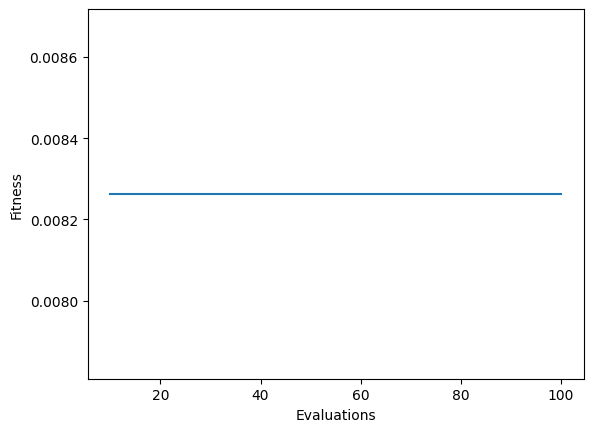

0.008262780227448252

In [56]:
config = {
    "env_name": "Walker-v0",
    "robot": walker,
    "generations": 10, # To change: increase!
    "lambda": 10,
    "max_steps": 100, # to change to 500
}

a = one_plus_lambda(config)
a.fitness

In [57]:
env = make_env(config["env_name"], robot=config["robot"])
evaluate(a, env, render=False)
env.close()

### Evolution Strategy

In [15]:
def ES(config):
    cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
    cfg = {**config, **cfg} # Merge configs
    
    # Update weights
    mu = cfg["mu"]
    w = np.array([np.log(mu + 0.5) - np.log(i)
                          for i in range(1, mu + 1)])
    w /= np.sum(w)
    
    env = make_env(cfg["env_name"], robot=cfg["robot"])

    # Center of the distribution
    elite = Agent(Network, cfg)
    elite.fitness = -np.inf
    theta = elite.genes
    d = len(theta)

    fits = []
    total_evals = []

    bar = tqdm(range(cfg["generations"]))
    for gen in bar:
        population = []
        for i in range(cfg["lambda"]):
            genes = theta + np.random.randn(len(theta)) * cfg["sigma"]
            ind = Agent(Network, cfg, genes=genes)
            population.append(ind)

        # with Pool(processes=len(population)) as pool:
        #     pop_fitness = pool.starmap(mp_eval, [(a, cfg) for a in population])
        
        pop_fitness = [evaluate(a, env, max_steps=cfg["max_steps"]) 
                       for a in population]
        
        for i in range(len(population)):
            population[i].fitness = pop_fitness[i]

        # sort by fitness
        inv_fitnesses = [- f for f in pop_fitness]
        # indices from highest fitness to lowest
        idx = np.argsort(inv_fitnesses)
        
        step = np.zeros(d)
        for i in range(mu):
            # update step
            step = step + w[i] * (population[idx[i]].genes - theta)
        # update theta
        theta = theta + step * cfg["lr"]

        if pop_fitness[idx[0]] > elite.fitness:
            elite.genes = population[idx[0]].genes
            elite.fitness = pop_fitness[idx[0]]

        fits.append(elite.fitness)
        total_evals.append(len(population) * (gen+1))

        bar.set_description(f"Best: {elite.fitness}")
        
    env.close()
    plt.plot(total_evals, fits)
    plt.xlabel("Evaluations")
    plt.ylabel("Fitness")
    plt.show()
    return elite

  0%|          | 0/10 [00:00<?, ?it/s]

Best: 0.46448296775599085: 100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


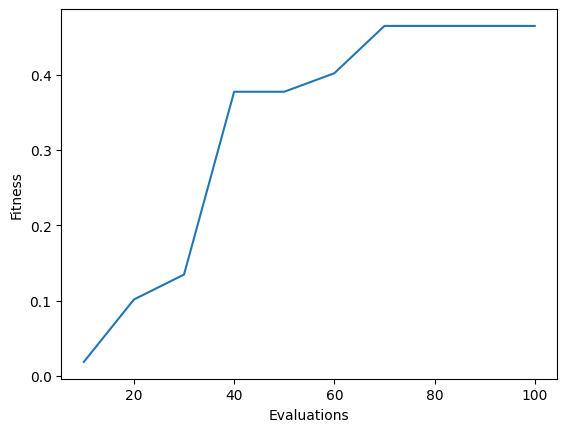

0.46448296775599085

In [ ]:
config = {
    "env_name": "Thrower-v0",
    "robot": walker,
    "generations": 10, # to change: increase!
    "lambda": 10, # Population size
    "mu": 5, # Parents pop size
    "sigma": 0.1, # mutation std
    "lr": 1, # Learning rate
    "max_steps": 100, # to change to 500
}

a = ES(config)
a.fitness

In [60]:
env = make_env(config["env_name"], robot=config["robot"])
evaluate(a, env, render=False)
env.close()

In [61]:
np.save("Thrower.npy", a.genes)

## Pre-trained walker

In [62]:
# load weights

config = {
    "env_name": "Thrower-v0",
    "robot": walker,
    "generations": 100,
    "lambda": 10, # Population size
    "mu": 5, # Parents pop size
    "sigma": 0.1, # mutation std
    "lr": 1, # Learning rate
    "max_steps": 500,
}

cfg = get_cfg(config["env_name"], robot=config["robot"]) # Get network dims
cfg = {**config, **cfg} # Merge configs
a = Agent(Network, cfg)
a.genes = np.load("Thrower.npy")


# Calculate the number of parameters
num_params = sum(p.numel() for p in a.model.parameters())
print(f'Total number of parameters: {num_params}')


Total number of parameters: 4341


In [63]:
env = make_env(cfg["env_name"], robot=cfg["robot"])
a.fitness = evaluate(a, env, render=False)
env.close()
print(a.fitness)

0.2558326637516918


In [64]:
import json
def save_solution(a, cfg, name="solution.json"):
    save_cfg = {}
    for i in ["env_name", "robot", "n_in", "h_size", "n_out"]:
        assert i in cfg, f"{i} not in config"
        save_cfg[i] = cfg[i]
    save_cfg["robot"] = cfg["robot"].tolist()
    save_cfg["genes"] = a.genes.tolist()
    save_cfg["fitness"] = float(a.fitness)
    # save
    with open(name, "w") as f:
        json.dump(save_cfg, f)
    return save_cfg

In [65]:
save_solution(a, cfg)

{'env_name': 'Thrower-v0',
 'robot': [[3, 3, 3, 3, 3],
  [3, 3, 3, 0, 3],
  [3, 3, 0, 3, 3],
  [3, 3, 0, 3, 3],
  [3, 3, 0, 3, 3]],
 'n_in': 80,
 'h_size': 32,
 'n_out': 21,
 'genes': [-0.5232559393922684,
  0.23664714086017186,
  -0.09065508017456787,
  -0.25462194035743435,
  -0.26903583163467854,
  0.044176619310290835,
  -0.2786216672647898,
  -0.1691414209322608,
  -0.03510080104097413,
  -0.17173235191321684,
  0.09840342127842584,
  -0.018773503561110336,
  -0.12066343419154407,
  0.02388678828507642,
  -0.22420096144117518,
  -0.027224473382301717,
  -0.1143741455293638,
  0.09961872893113437,
  -0.2034258672280418,
  0.36603077772879894,
  -0.10841397780001986,
  0.3271241369253762,
  0.003737486956883855,
  0.181272244065579,
  -0.26465741493807327,
  -0.061821617944338256,
  -0.12988747815125795,
  0.060664388778857326,
  -0.1476150625829025,
  0.10960530727971071,
  0.22413607346067382,
  0.2041600915186877,
  -0.20611036541925584,
  -0.19439496055966496,
  0.13236410751578

In [66]:
def load_solution(name="solution.json"):
    with open(name, "r") as f:
        cfg = json.load(f)
    cfg["robot"] = np.array(cfg["robot"])
    cfg["genes"] = np.array(cfg["genes"])
    a = Agent(Network, cfg, genes=cfg["genes"])
    a.fitness = cfg["fitness"]
    return a

In [68]:
a = load_solution(name="solution.json")
cfg = a.config
env = make_env(cfg["env_name"], robot=cfg["robot"])
a.fitness = evaluate(a, env, render=False)
env.close()
print(a.fitness)

0.2558326637516918
